In [2]:
%pip install pandas numpy matplotlib statsmodels scikit-learn openpyxl


Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#import the dataset
file_path = r"/Users/binga17/Downloads/MSBA/3rd sem/Financial Analytics/Assignments/Walmart_Sales.xlsx"

df = pd.read_excel(file_path)  
print(df.head())

   Store                 Date  Weekly_Sales  Holiday_Flag  Temperature  \
0      1  2010-05-02 00:00:00    1643690.90             0        42.31   
1      1  2010-12-02 00:00:00    1641957.44             1        38.51   
2      1           19-02-2010    1611968.17             0        39.93   
3      1           26-02-2010    1409727.59             0        46.63   
4      1  2010-05-03 00:00:00    1554806.68             0        46.50   

   Fuel_Price         CPI  Unemployment  
0       2.572  211.096358         8.106  
1       2.548  211.242170         8.106  
2       2.514  211.289143         8.106  
3       2.561  211.319643         8.106  
4       2.625  211.350143         8.106  


In [12]:
# the columns we need
data = df[["Date", "Weekly_Sales"]].copy()
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")
data = data.dropna(subset=["Date"])
data["Weekly_Sales"] = pd.to_numeric(data["Weekly_Sales"], errors="coerce")
data = data.dropna(subset=["Weekly_Sales"]).sort_values("Date").set_index("Date")

# Weekly → Monthly totals
monthly = data["Weekly_Sales"].resample("ME").sum().to_frame(name="Monthly_Sales")
print(monthly.head(12))

            Monthly_Sales
Date                     
2010-01-31   4.223988e+07
2010-02-28   1.915869e+08
2010-03-31   1.862262e+08
2010-04-30   1.838118e+08
2010-05-31   2.806119e+08
2010-06-30   1.424361e+08
2010-07-31   1.842664e+08
2010-08-31   1.845381e+08
2010-09-30   1.797041e+08
2010-10-31   2.311201e+08
2010-11-30   1.587731e+08
2010-12-31   3.235716e+08


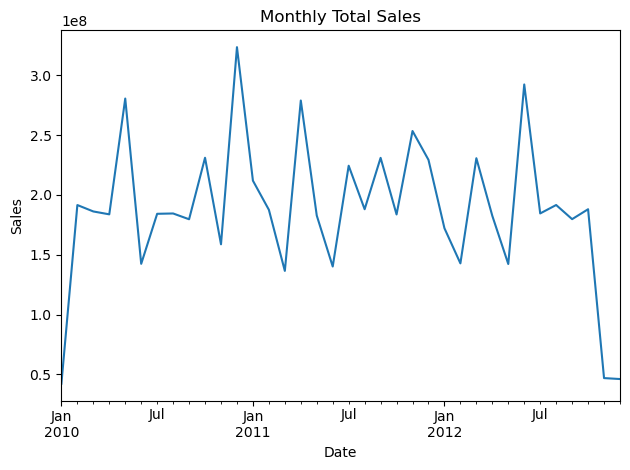

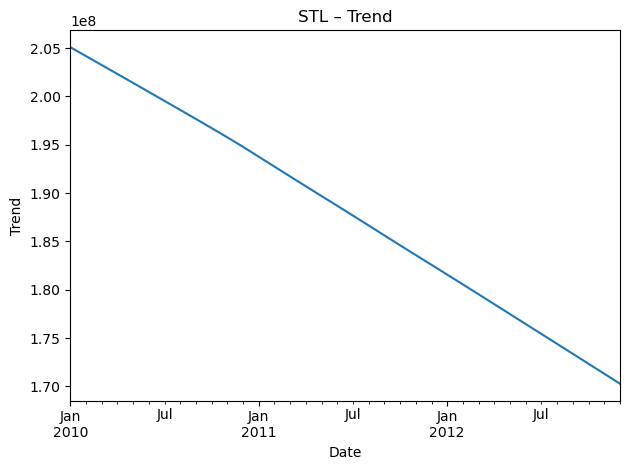

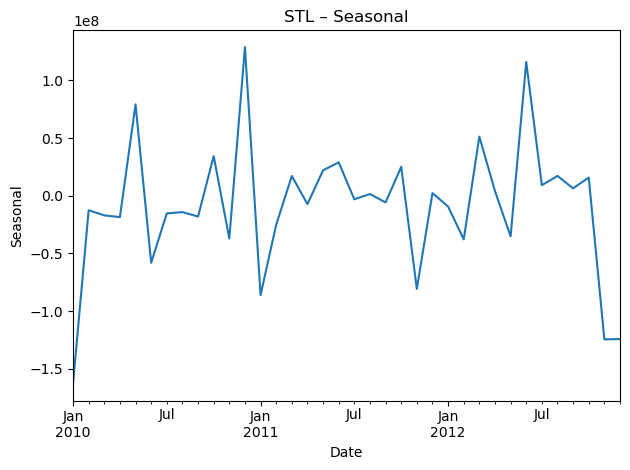

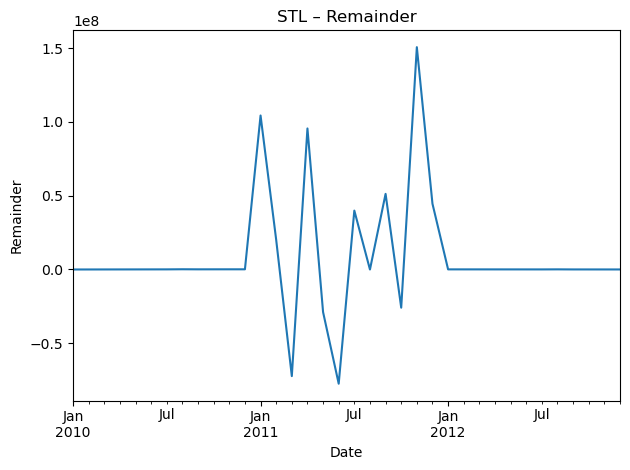

In [14]:
#STl decomposition
from statsmodels.tsa.seasonal import STL

stl = STL(monthly["Monthly_Sales"], period=12, robust=True)
res = stl.fit()

# Plot
plt.figure(); monthly["Monthly_Sales"].plot(title="Monthly Total Sales"); plt.xlabel("Date"); plt.ylabel("Sales"); plt.tight_layout()

plt.figure(); res.trend.plot(title="STL – Trend"); plt.xlabel("Date"); plt.ylabel("Trend"); plt.tight_layout()
plt.figure(); res.seasonal.plot(title="STL – Seasonal"); plt.xlabel("Date"); plt.ylabel("Seasonal"); plt.tight_layout()
plt.figure(); res.resid.plot(title="STL – Remainder"); plt.xlabel("Date"); plt.ylabel("Remainder"); plt.tight_layout()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE: 113,787,076.00 | MAPE: 102.03%


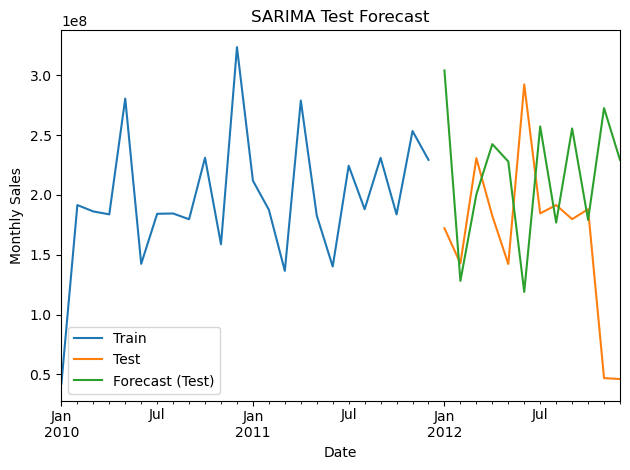

In [22]:
#SARIMA forecast $ Forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np, math
import matplotlib.pyplot as plt

y = monthly["Monthly_Sales"].asfreq("ME")
h = 12 if len(y) > 24 else max(3, len(y)//4)  # test horizon

train, test = y.iloc[:-h], y.iloc[-h:]

model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(0,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

fc = res.get_forecast(steps=h).predicted_mean

rmse = math.sqrt(mean_squared_error(test, fc))
mape = (np.abs((test - fc) / test)
        .replace([np.inf, -np.inf], np.nan).dropna().mean() * 100)

print(f"RMSE: {rmse:,.2f} | MAPE: {mape:.2f}%")

plt.figure()
train.plot(label="Train")
test.plot(label="Test")
fc.plot(label="Forecast (Test)")
plt.title("SARIMA Test Forecast")
plt.xlabel("Date"); plt.ylabel("Monthly Sales")
plt.legend(); plt.tight_layout()


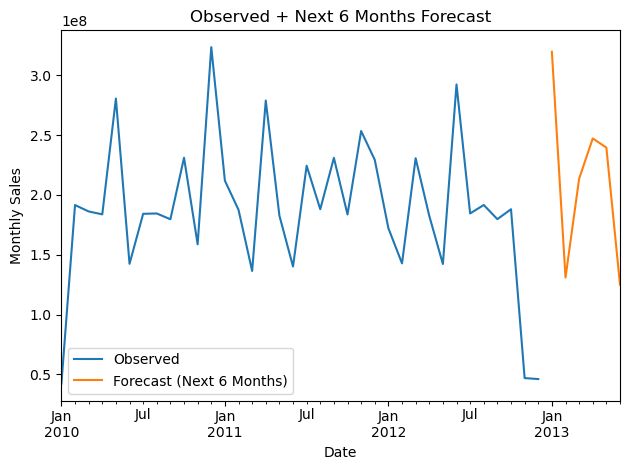

In [32]:
#Forecasting for the next six months

future_steps = 6
future_fc = res_model.get_forecast(steps=test_horizon + future_steps).predicted_mean
future_fc = future_fc.iloc[test_horizon:]  # next 6 months beyond test

plt.figure()
monthly["Monthly_Sales"].plot(label="Observed")
future_fc.plot(label="Forecast (Next 6 Months)")
plt.title("Observed + Next 6 Months Forecast")
plt.xlabel("Date"); plt.ylabel("Monthly Sales"); plt.legend(); plt.tight_layout()